# Qualifying

In [4]:
import fastf1
import fastf1.plotting
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from openpyxl.styles import PatternFill
from openpyxl import Workbook
from openpyxl import load_workbook
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import matplotlib.image as image


# enabling misc_mpl_mods will turn on minor grid lines that clutters the plot
fastf1.plotting.setup_mpl(mpl_timedelta_support=False, misc_mpl_mods=False)

In [5]:
ses = 3
race = 18

In [6]:
session = fastf1.get_session(2023,race,ses)
session.load()


logger      WARNING 	Failed to load schedule from FastF1 backend!
req            INFO 	No cached data found for season_schedule. Loading data...
_api           INFO 	Fetching season schedule...


req            INFO 	Data has been written to cache!
logger      WARNING 	Failed to load schedule from F1 API backend!
core           INFO 	Loading data for United States Grand Prix - Sprint Shootout [v3.1.2]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
core        WARNING 	No result data for this session available on Ergast! (This is expected for recent sessions)
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching track status data...
req 

### Pre Defined

In [7]:
# Set display options to show all columns
pd.set_option('display.max_columns', None)

compounds = fastf1.plotting.COMPOUND_COLORS
# convert dictionary to dataframe
compoundcolor = pd.DataFrame.from_dict(compounds, orient='index', columns=['CompoundColor'])
# add compound column
compoundcolor['Compound'] = compoundcolor.index
# reset index
compoundcolor = compoundcolor.reset_index(drop=True)


In [25]:
# getting laps of session
laps = session.laps 

# adding lap time in seconds
laps['LapTimeS'] = laps["LapTime"].dt.total_seconds()
laps["LapTimeS"] = laps["LapTimeS"] - 60 # correcting lap time

# adding lap time start in seconds
laps['LapStartTimeS'] = laps["LapStartTime"].dt.total_seconds()

# adding lap time end in seconds
laps['DeltaTime'] = 0 # add column Delta time filled with 0

# getting max lap of session
max_lap = int(session.laps["LapNumber"].max())

#results of race
results = session.results

#correcting team color
results["TeamColor"] = [fastf1.plotting.team_color(i) for i in results["TeamName"]] 

# drivers list
drivers = session.drivers

# Drivers Start order 
drivers_start = results[["DriverNumber","GridPosition"]].sort_values(by=['GridPosition'])
drivers_start = drivers_start["DriverNumber"].values

#drivers abreviation
drivers_abr = [session.get_driver(driver)["Abbreviation"] for driver in drivers]

# Drivers Start order 
drivers_start_abr = results[["Abbreviation","GridPosition"]].sort_values(by=['GridPosition'])
drivers_start_abr = drivers_start_abr["Abbreviation"].values

# Teams list 
teams = results["TeamName"].unique()

#race name 
race_name = session.event["EventName"]
session_name = session.event["Session"+str(ses)]

### Qualifying results 

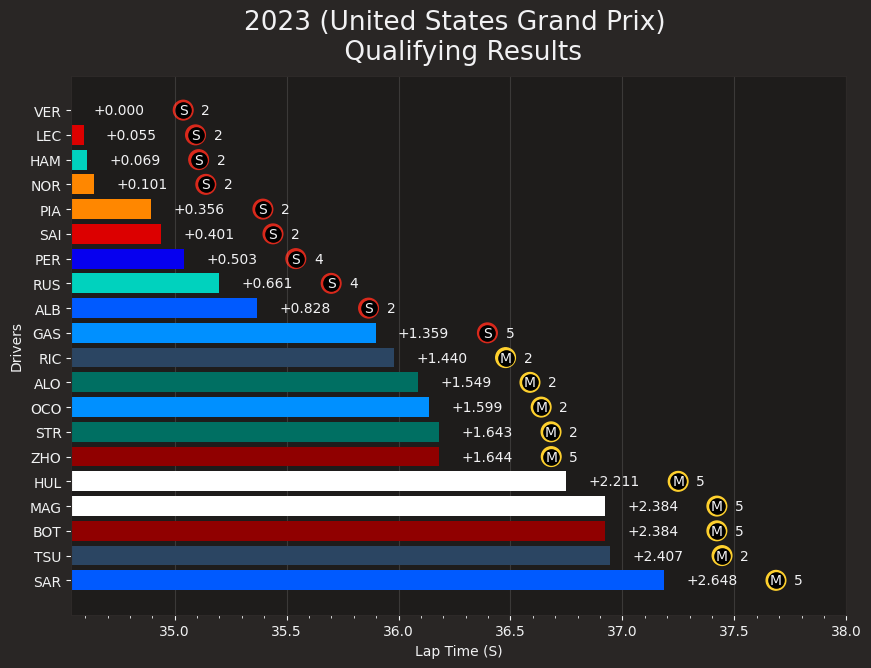

In [9]:
q1, q2, q3 = laps.split_qualifying_sessions()
q1_results = pd.DataFrame()
q2_results = pd.DataFrame()
q3_results = pd.DataFrame()
y=0
for i in drivers:
    y+=1
    if((q1.pick_driver(i).empty == False) & (y > 15)):
        if (q1.pick_driver(i).pick_fastest().isna().all()):
            lap = q1.pick_driver(i).pick_lap(q1.pick_driver(i)["LapNumber"].min()).T
        else:
            lap = q1.pick_driver(i).pick_fastest()
        q1_results = pd.concat([q1_results, pd.DataFrame(lap).T.reset_index(drop=True)], ignore_index=True)
    if((q2.pick_driver(i).empty == False) & (16 > y > 10)):
        if (q2.pick_driver(i).pick_fastest().isna().all()):
            lap = q2.pick_driver(i).pick_lap(q2.pick_driver(i)["LapNumber"].min()).T
        else:
            lap = q2.pick_driver(i).pick_fastest()
        q2_results = pd.concat([q2_results, pd.DataFrame(lap).T.reset_index(drop=True)], ignore_index=True)
    if((q3.pick_driver(i).empty == False) & (y < 11)):
        if (q3.pick_driver(i).pick_fastest().isna().all()):
            lap = q3.pick_driver(i)
            lap = lap.loc[lap["Deleted"]==False].T
            print('not time setted driver '+i)
        else:
            lap = q3.pick_driver(i).pick_fastest()
        q3_results = pd.concat([q3_results, pd.DataFrame(lap).T.reset_index(drop=True)], ignore_index=True)
results_qualifying = pd.concat([q3_results,q2_results,q1_results], ignore_index=True).reset_index(drop=True)
# calculate gap to P1
results_qualifying['LapTimeS'] = results_qualifying['LapTimeS'].fillna(results_qualifying["LapTimeS"].min())
results_qualifying["DeltaTime"] = results_qualifying["LapTimeS"]-results_qualifying["LapTimeS"].min()
diff = (results_qualifying.loc[results_qualifying["DeltaTime"]>7,['LapTimeS']] - results_qualifying.loc[results_qualifying["DeltaTime"]>7,['DeltaTime']].values)
results_qualifying.loc[results_qualifying["DeltaTime"]>7,['LapTimeS']] = diff
results_qualifying = pd.merge(results_qualifying, results[["DriverNumber","TeamColor"]], on='DriverNumber')
results_qualifying = pd.merge(results_qualifying, compoundcolor[["Compound","CompoundColor"]], on='Compound')


# Ploting Graph ------------------------------------

plt.figure(figsize=(10, 7))

# Load your logo image (replace 'logo.png' with the actual filename)
# logo = plt.imread('logo/LogoFomulaRcmDark.png')

y = results_qualifying["Driver"]
x = results_qualifying["LapTimeS"]
minx = results_qualifying["LapTimeS"].min()
maxx = results_qualifying["LapTimeS"].max()
color = results_qualifying["TeamColor"]
# Create the horizontal bar plot
a = 0.5
plt.barh(y,x , color = color)
plt.scatter(x+a,y , color = results_qualifying["CompoundColor"], marker='o', s=200, zorder=0)
plt.scatter(x+a,y , color = "Black", marker='o', s=120, zorder=0)

# Set labels and title
plt.xlabel('Lap Time (S)')
plt.ylabel('Drivers')
plt.title('2023 ('+session.event["EventName"]+') \n Qualifying Results')
plt.xticks(range(0, 60, 1))
plt.xlim(minx, 38)
plt.gca().invert_yaxis()
# Set the y-axis ticker to display integer values with increments of 0.1
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1))

plt.grid(axis='x',alpha = 0.2)


# Add text annotations near each bar
for i in range(0,len(y)):
    if ((i > 0) and (results_qualifying["DeltaTime"][i] == 0)):
        plt.text(results_qualifying["LapTimeS"][i] + 0.1, i,"No Time", va='center')       
    else:
        plt.text(results_qualifying["LapTimeS"][i] + 0.1, i, "+"+"{:.3f}".format(results_qualifying["DeltaTime"][i]), va='center')
        
    
    plt.text(results_qualifying["LapTimeS"][i] + a, i,results_qualifying["Compound"][i][0], va='center', ha = 'center')
    plt.text(results_qualifying["LapTimeS"][i] + a+0.1, i,int(results_qualifying["TyreLife"][i]), va='center', ha = 'center')


# Display the plot
plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/2023_'+race_name+'_Results_Qualifying.png', dpi=200, bbox_inches='tight')

plt.show()

### Checking Order

In [10]:
if((results_qualifying["DriverNumber"].values == results["DriverNumber"].values).any()):
    results = pd.merge(results_qualifying["DriverNumber"], results, on='DriverNumber')
    print(results["DriverNumber"].values)
    # drivers list
    drivers = results["DriverNumber"].values

    # Drivers Start order 
    drivers_start = results[["DriverNumber","GridPosition"]].sort_values(by=['GridPosition'])
    drivers_start = drivers_start["DriverNumber"].values

    #drivers abreviation
    drivers_abr = [session.get_driver(driver)["Abbreviation"] for driver in drivers]

    # Drivers Start order 
    drivers_start_abr = results[["Abbreviation","GridPosition"]].sort_values(by=['GridPosition'])
    drivers_start_abr = drivers_start_abr["Abbreviation"].values


['1' '16' '44' '4' '81' '55' '11' '63' '23' '10' '3' '14' '31' '18' '24'
 '27' '20' '77' '22' '2']


### Top Speed Qualifying 

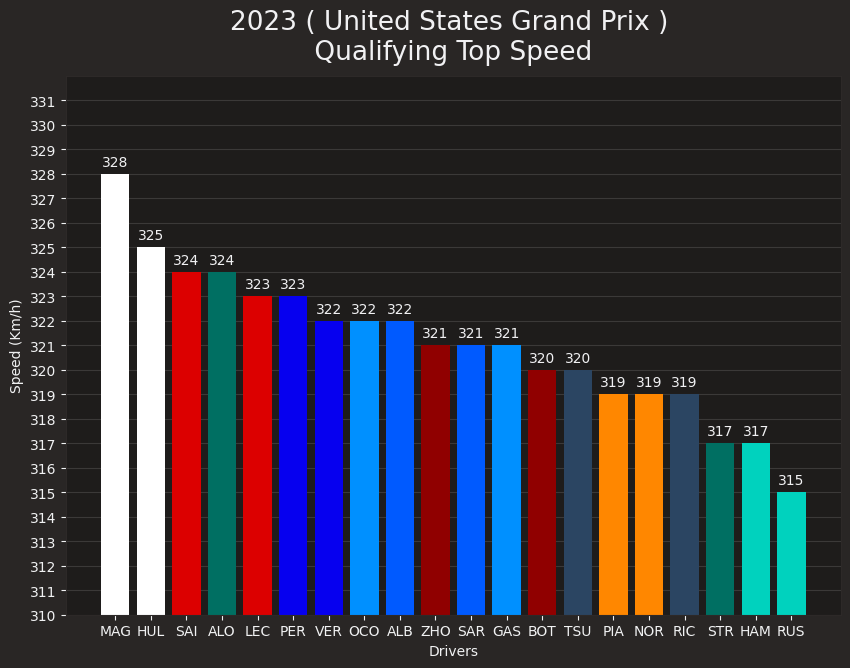

In [11]:
team_list = []
driver_list = []
DriverAB_list = []
top_speed_list = []
color_list = []

for i in drivers:
    lap = laps.loc[laps["DriverNumber"]==i]
    if (lap.empty or lap["LapTime"].isna().all()):
        print("The DataFrame is empty driver: ",i)
    else:
        max_speed = lap.pick_fastest().get_car_data()
        team_list.append(session.get_driver(i)["TeamName"])
        driver_list.append(i)
        DriverAB_list.append(results.loc[results["DriverNumber"] == i,"Abbreviation"].values[0])
        top_speed_list.append(max_speed["Speed"].max())
        color_list.append(fastf1.plotting.team_color(session.get_driver(i)["TeamName"]))

df_top_speed = pd.DataFrame({
    'TeamName': team_list,
    'DriverNumber': driver_list,
    'Driver': DriverAB_list,
    'TopSpeed': top_speed_list,
    'Color': color_list
})

df_top_speed = df_top_speed.sort_values(by='TopSpeed', ascending=False).reset_index(drop=True)

#Plotting Qualifying Lap Time

plt.figure(figsize=(10, 7))
x = df_top_speed["Driver"].reset_index(drop=True)
y = df_top_speed["TopSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_top_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('Speed (Km/h)')
plt.title('2023 ( '+race_name+' ) \n Qualifying Top Speed ')
plt.yticks(range(int(df_top_speed["TopSpeed"].min())-20, int(df_top_speed["TopSpeed"].max())+4,1))
plt.ylim(int(df_top_speed["TopSpeed"].min())-5,int(df_top_speed["TopSpeed"].max()) +4)
plt.grid(axis='y', alpha=0.2)

# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.2, str(y.loc[i]), ha='center', va='bottom')

# Save the figure and show
plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/2023_'+race_name+'_Qualifying_top_speed.png', dpi=200, bbox_inches='tight')
# Display the plot
plt.show()

### Average throttle 

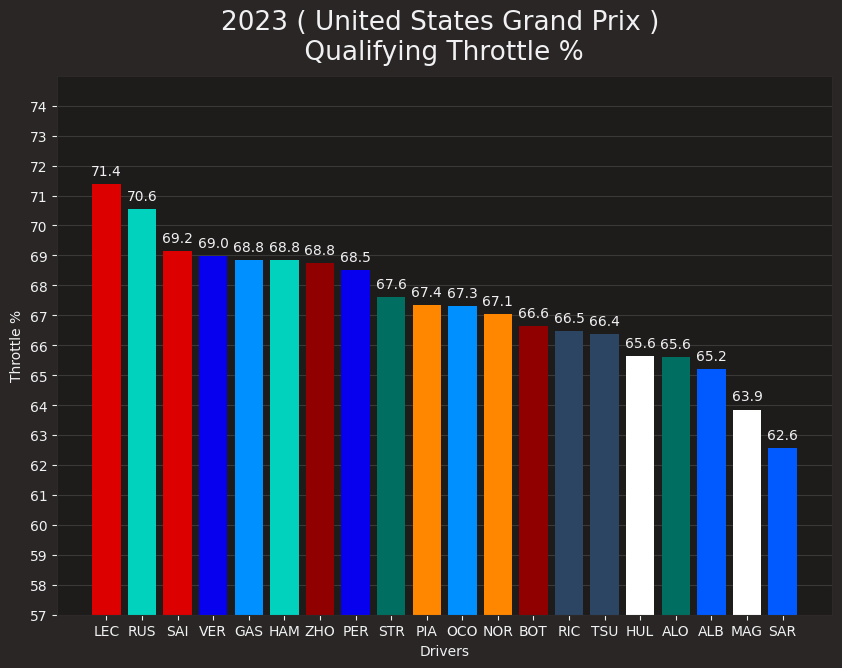

In [12]:
laps_session = laps

driver_list = []
DriverAB_list = []
throttle_list = []
color_list = []


for i in drivers:
    lap = laps_session.pick_driver(i).pick_fastest()
    x = lap["Driver"]
    y = lap.get_car_data()['Throttle'].mean()
    
    driver_list.append(i)
    DriverAB_list.append(lap["Driver"])
    throttle_list.append(y)
    color_list.append(fastf1.plotting.team_color(session.get_driver(i)["TeamName"]))

df_throttle = pd.DataFrame({
    'DriverNumber': driver_list,
    'Driver': DriverAB_list,
    'Throttle': throttle_list,
    'Color': color_list
})

#Cleaning data 

df_throttle = df_throttle.sort_values(by='Throttle', ascending=False).reset_index(drop=True)
df_throttle = df_throttle.loc[df_throttle["Throttle"]>df_throttle["Throttle"].mean()-10]

#Plotting Qualifying Lap Time

plt.figure(figsize=(10, 7))
x = df_throttle["Driver"].reset_index(drop=True)
y = df_throttle["Throttle"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_throttle["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('Throttle %')
plt.title('2023 ( '+race_name+' ) \n Qualifying Throttle % ')
plt.yticks(range(int(df_throttle["Throttle"].min())-20, int(df_throttle["Throttle"].max())+4,1))
plt.ylim(int(df_throttle["Throttle"].min())-5,int(df_throttle["Throttle"].max()) +4)
plt.grid(axis='y', alpha=0.2)

# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.2,"{:.1f}".format(y.loc[i]), ha='center', va='bottom')

# Save the figure and show
plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/2023_'+race_name+'_Qualifying_throttle.png', dpi=200, bbox_inches='tight')
# Display the plot
plt.show()

### Top Speed by team

C:\Users\GTR\AppData\Local\Temp\ipykernel_11080\3043559.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_team_top_speed = df_top_speed.groupby(['TeamName','Color']).mean().sort_values(by='TopSpeed', ascending=False).reset_index()


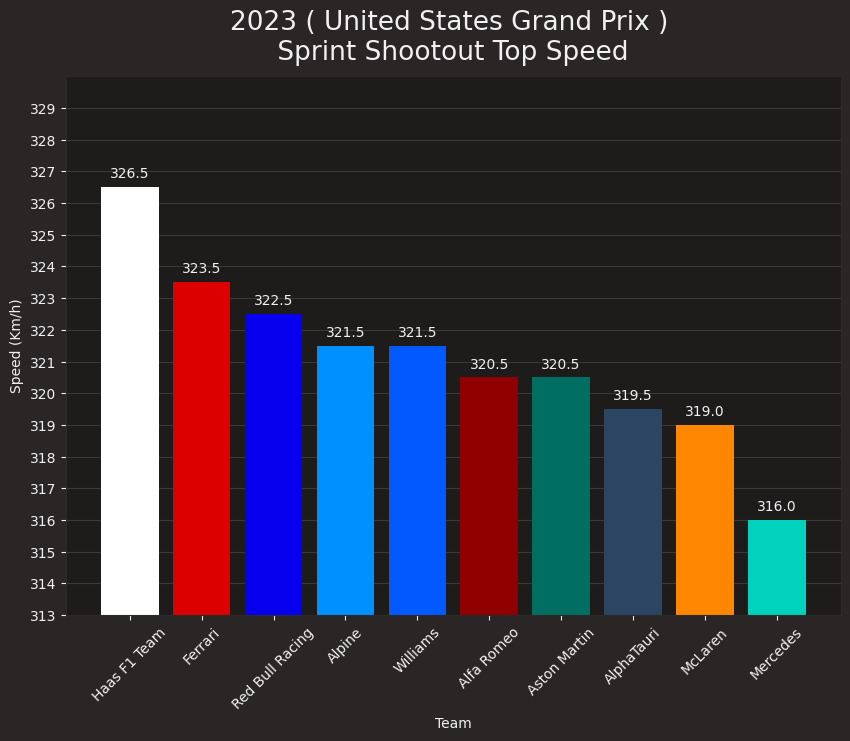

In [24]:
df_team_top_speed = df_top_speed.groupby(['TeamName','Color']).mean().sort_values(by='TopSpeed', ascending=False).reset_index()
plt.figure(figsize=(10, 7))
x = df_team_top_speed["TeamName"].reset_index(drop=True)
y = df_team_top_speed["TopSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_team_top_speed["Color"])

# Add labels and title
plt.xlabel('Team')
plt.xticks(rotation=45)
plt.ylabel('Speed (Km/h)')
plt.title('2023 ( '+race_name+' ) \n '+session.event["Session"+str(ses)]+' Top Speed ')
plt.yticks(range(int(df_team_top_speed["TopSpeed"].min())-20, int(df_team_top_speed["TopSpeed"].max())+4,1))
plt.ylim(int(df_team_top_speed["TopSpeed"].min())-3,int(df_team_top_speed["TopSpeed"].max()) +4)
plt.grid(axis='y', alpha=0.2)

# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.2, str(y.loc[i]), ha='center', va='bottom')

# Save the figure and show
plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/2023_'+race_name+'_Qualifying_top_speed_team.png', dpi=200, bbox_inches='tight')
# Display the plot
plt.show()

### Low Speed

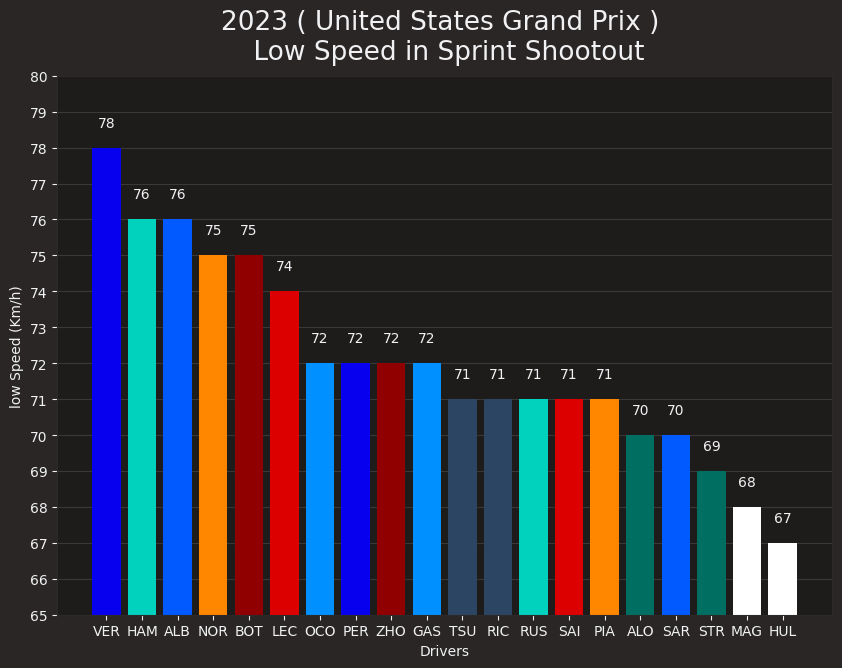

In [14]:
driver_list = []
DriverAB_list = []
low_speed_list = []
color_list = []

for i in drivers:
    if laps.pick_driver(i).empty:
        print("The DataFrame is empty")
    else:
        min_speed = laps.pick_driver(i).pick_fastest().get_car_data()
        low_Speed = min_speed.loc[min_speed['Speed'].idxmin(),"Speed"]

        driver_list.append(i)
        DriverAB_list.append(session.get_driver(i)[["Abbreviation"]].values[0])
        low_speed_list.append(low_Speed)
        color_list.append(fastf1.plotting.team_color(session.get_driver(i)["TeamName"]))

df_low_speed = pd.DataFrame({
    'DriverNumber': driver_list,
    'Driver': DriverAB_list,
    'lowSpeed': low_speed_list,
    'Color': color_list
})
df_low_speed = df_low_speed.sort_values(by='lowSpeed', ascending=False)
df_low_speed = df_low_speed.loc[df_low_speed["lowSpeed"]>df_low_speed["lowSpeed"].mean()-10]

# ploting the low speed

plt.figure(figsize=(10, 7))
x = df_low_speed["Driver"].reset_index(drop=True)
y = df_low_speed["lowSpeed"].reset_index(drop=True)
max = df_low_speed["lowSpeed"].max()
min = df_low_speed["lowSpeed"].min()
# Create the bar plot
plt.bar(x, y,color = df_low_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('low Speed (Km/h)')
plt.title('2023 ( '+session.event["EventName"]+' ) \n Low Speed in '+session.event["Session"+str(ses)])
plt.yticks(range(0, 400, 1))
plt.ylim(min-2, max+2)
# Add text annotations on low of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.5, str(y.loc[i]), ha='center', va='bottom')
    
plt.grid(axis='y', alpha=0.2)
# Display the plot
plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/low_Speed_'+session.event["Session"+str(ses)]+'.png', dpi=200, bbox_inches='tight')
plt.show()

### Fastest Lap Average Speed

In [15]:
session.get_driver('1')["TeamName"]

'Red Bull Racing'

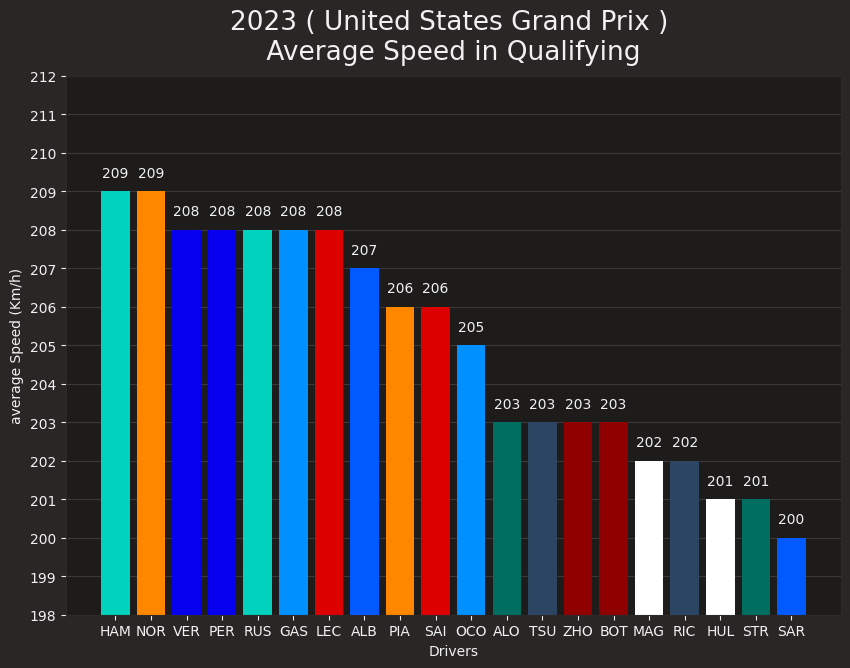

In [16]:
team_list = []
driver_list = []
DriverAB_list = []
avg_speed_list = []
color_list = []

for i in drivers:
    if laps.pick_driver(i).empty:
        print("The DataFrame is empty")
    else:
        max_speed = laps.pick_driver(i).pick_fastest().get_car_data()
        avg_Speed = round(max_speed["Speed"].mean())

        team_list.append(session.get_driver(i)["TeamName"])
        driver_list.append(i)
        DriverAB_list.append(session.get_driver(i)[["Abbreviation"]].values[0])
        avg_speed_list.append(avg_Speed)
        color_list.append(fastf1.plotting.team_color(session.get_driver(i)["TeamName"]))

df_avg_speed = pd.DataFrame({
    'TeamName': team_list,
    'DriverNumber': driver_list,
    'Driver': DriverAB_list,
    'AvgSpeed': avg_speed_list,
    'Color': color_list
})


df_avg_speed = df_avg_speed.sort_values(by='AvgSpeed', ascending=False)
df_avg_speed = df_avg_speed.loc[df_avg_speed["AvgSpeed"]>df_avg_speed["AvgSpeed"].mean()-30]

# ploting the average speed


plt.figure(figsize=(10, 7))
x = df_avg_speed["Driver"].reset_index(drop=True)
y = df_avg_speed["AvgSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_avg_speed["Color"])

# Add labels and title
plt.xlabel('Drivers')
plt.ylabel('average Speed (Km/h)')
plt.title('2023 ( '+session.event["EventName"]+' ) \n Average Speed in Qualifying ')
plt.yticks(range(0, 250, 1))
plt.ylim(y.min()-2, y.max()+3)
# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.3, str(y.loc[i]), ha='center', va='bottom')

plt.grid(axis='y', alpha=0.2)

plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/avg_Speed_'+session.event["Session"+str(ses)]+'.png', dpi=200, bbox_inches='tight')

# Display the plot
plt.show()

In [17]:
df_team_avg_speed = df_avg_speed.groupby(['TeamName','Color']).mean().sort_values(by='AvgSpeed', ascending=False).reset_index()

C:\Users\GTR\AppData\Local\Temp\ipykernel_11080\3390521719.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_team_avg_speed = df_avg_speed.groupby(['TeamName','Color']).mean().sort_values(by='AvgSpeed', ascending=False).reset_index()


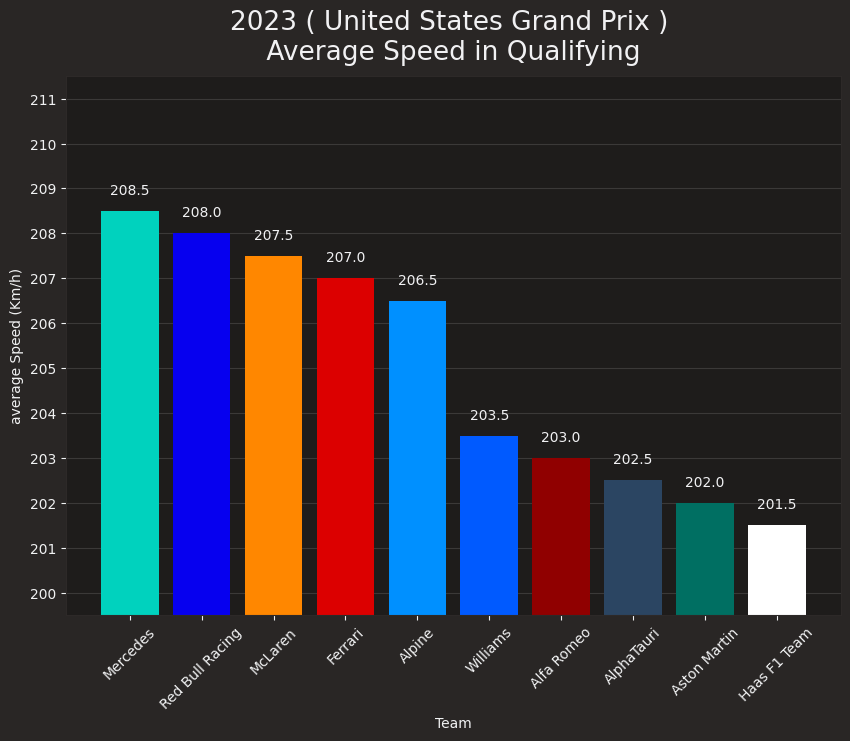

In [18]:
# ploting the average speed


plt.figure(figsize=(10, 7))
x = df_team_avg_speed["TeamName"].reset_index(drop=True)
y = df_team_avg_speed["AvgSpeed"].reset_index(drop=True)

# Create the bar plot
plt.bar(x, y,color = df_team_avg_speed["Color"])

# Add labels and title
plt.xlabel('Team')
plt.xticks(rotation=45)
plt.ylabel('average Speed (Km/h)')
plt.title('2023 ( '+session.event["EventName"]+' ) \n Average Speed in Qualifying ')
plt.yticks(range(0, 250, 1))
plt.ylim(y.min()-2, y.max()+3)
# Add text annotations on top of bars
for i in range(len(x)):
    plt.text(i, y.loc[i]+0.3, str(y.loc[i]), ha='center', va='bottom')

plt.grid(axis='y', alpha=0.2)

plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/avg_Speed_'+session.event["Session"+str(ses)]+'.png', dpi=200, bbox_inches='tight')

# Display the plot
plt.show()

### Efficiency

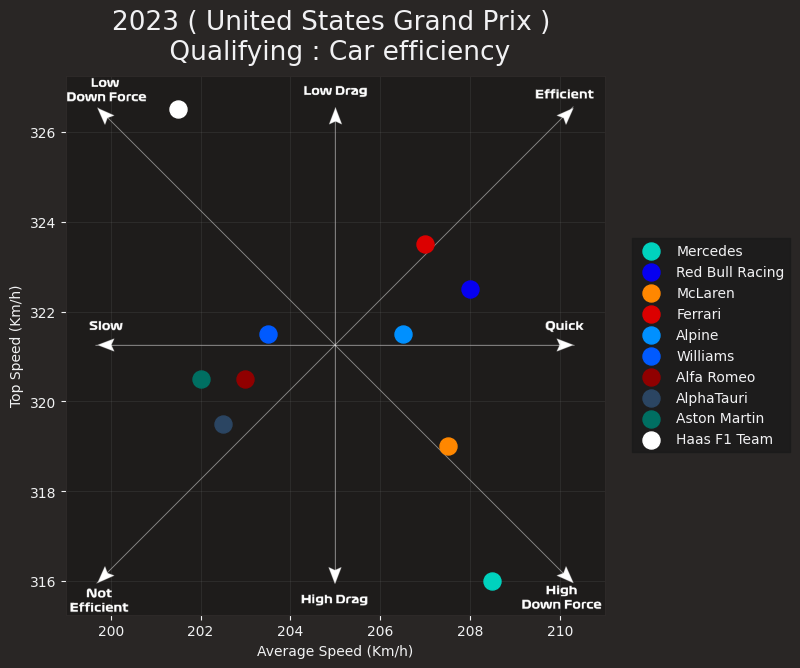

In [19]:
efficiency = pd.merge(df_team_avg_speed, df_team_top_speed[["TeamName","TopSpeed"]], on='TeamName')

x_center = (efficiency["AvgSpeed"].max() + efficiency["AvgSpeed"].min())/2
y_center = (efficiency["TopSpeed"].max() + efficiency["TopSpeed"].min())/2

plt.figure(figsize=(7, 7))
x = efficiency["AvgSpeed"].reset_index(drop=True)
y = efficiency["TopSpeed"].reset_index(drop=True)
teams = efficiency['TeamName'].values

# Create the bar plot
# plt.scatter(x, y,color = efficiency["Color"],label = ['a','b'],s=200)
# plt.axvline(x_center, color='White', linestyle='solid', linewidth=1)
# plt.axhline(y_center, color='White', linestyle='solid', linewidth=1)

for i in range(len(x)):
    plt.scatter(x[i], y[i],color = efficiency["Color"][i],label = teams[i],s=150)


# Add labels and title
plt.xlabel('Average Speed (Km/h)')
# plt.xticks(rotation=45)
plt.ylabel('Top Speed (Km/h)')
plt.title('2023 ( '+session.event["EventName"]+' ) \n Qualifying : Car efficiency')
# plt.yticks(range(0, 250, 1))
# plt.ylim(y.min()-2, y.max()+3)
# Add text annotations on top of bars
# for i in range(len(x)):
#     plt.text(i, y.loc[i]+0.3, str(y.loc[i]), ha='center', va='bottom')

# Read the image file into a NumPy array
graph = image.imread("logo/graph effeciency02y.png")
a=6
plt.imshow(graph, extent=[x_center-a, x_center+a, y_center-a, y_center+a])

plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', borderaxespad=0.)
plt.grid(True, alpha=0.1)

plt.savefig('C:/Users/GTR/Pictures/Graphes/Qualifying/Effeciency'+session.event["Session"+str(ses)]+'.png', dpi=200, bbox_inches='tight')

# Display the plot
plt.show()

### Lap time Qualifying

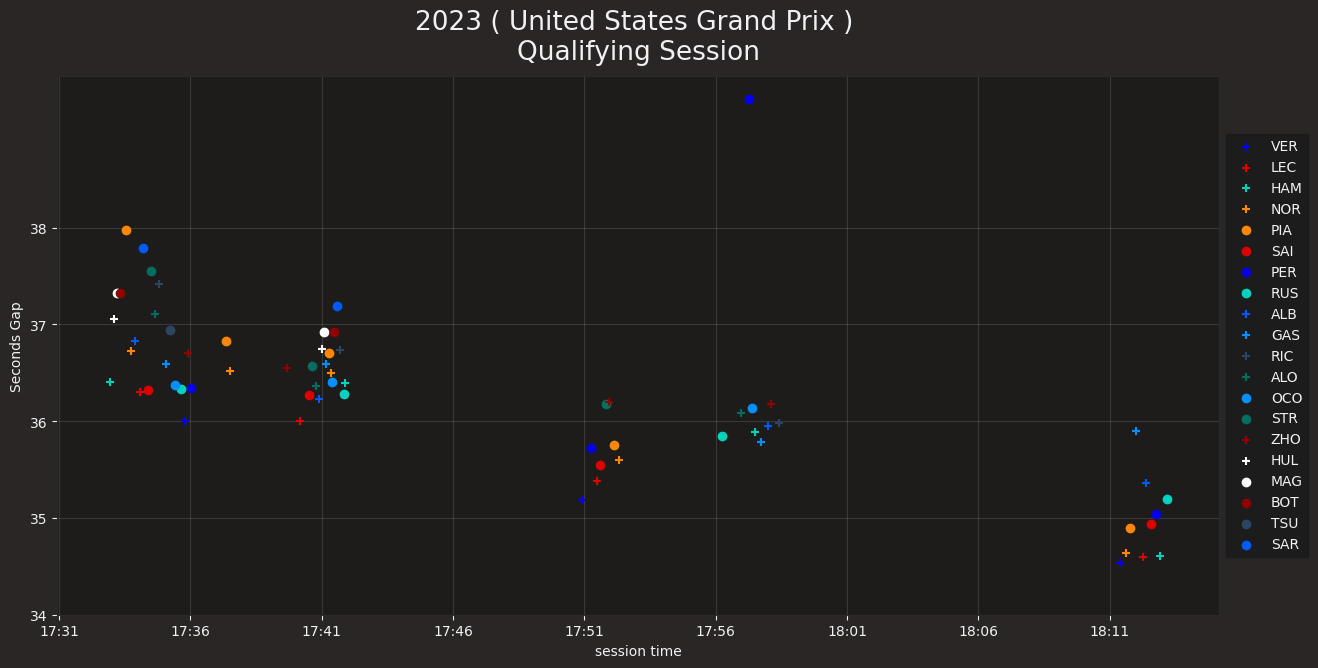

In [20]:
comp = " "
if comp == " ":
    laps_session = laps[["DriverNumber","Driver","LapNumber","LapStartDate","LapTime"]].pick_quicklaps()
else :  
    laps_session = laps[["DriverNumber","Driver","LapNumber","LapStartDate","Compound","LapTime"]].pick_compounds(comp).pick_quicklaps()
laps_session["LapTimeS"] = laps_session["LapTime"].dt.total_seconds()
laps_session["LapTimeS"] = laps_session["LapTimeS"] - 60
laps_session["LapStartDate"] = pd.to_datetime(laps_session["LapStartDate"])
laps_session["LapStartDateM"] = laps_session["LapStartDate"].dt.strftime('%H:%M')

# plotting graph

plt.figure(figsize=(15, 7))

color_picked = []
max_lap_time = int(laps_session["LapTimeS"].max())
min_lap_time = int(laps_session["LapTimeS"].min())

for i in drivers:
    lap_ordred = laps_session.loc[laps_session["DriverNumber"] == i].sort_values(by='LapStartDateM', ascending=True)
    x = lap_ordred["LapStartDate"]
    y = lap_ordred["LapTimeS"]

    driver_name = session.get_driver(i)["Abbreviation"]
    team_color = session.get_driver(i)["TeamColor"]
    
    if team_color in color_picked:
        plt.scatter(x, y, color=team_color, marker='o', label=driver_name)
    else:    
        plt.scatter(x, y, color=team_color, marker='+', label=driver_name)
        color_picked.append(team_color)
# Set the x-axis formatter
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

# Set the x-axis locator
locator = mdates.MinuteLocator(interval=5)
plt.gca().xaxis.set_major_locator(locator)

# Customize the plot
plt.title('2023 ( '+session.event["EventName"]+' ) \nQualifying Session')
plt.xlabel('session time')
plt.ylabel('Seconds Gap')

plt.yticks(range(min_lap_time, max_lap_time, 1))

plt.grid(True, alpha=0.2)

# Add legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))



# Display the plot
plt.show()


### Sectors Table

In [21]:
table_results = results_qualifying[["Driver","Sector1Time","Sector2Time","Sector3Time","LapTime","DeltaTime"]].dropna()

def highlight_min(s):
    is_min = s == s.min()
    return ['color: purple' if v else '' for v in is_min]

# Apply the styling using apply()
styled_df = table_results.style.apply(highlight_min, subset=['Sector1Time','Sector2Time','Sector3Time','LapTime'])
# Define the CSS styling for the header
header_styles = [
    {'selector': 'th',
     'props': [('background-color', 'purple'), ('color', 'white')]}
]

styled_df

,Driver,Sector1Time,Sector2Time,Sector3Time,LapTime,DeltaTime
0,VER,0 days 00:00:25.461000,0 days 00:00:38.160000,0 days 00:00:30.917000,0 days 00:01:34.538000,0.000000
1,LEC,0 days 00:00:25.555000,0 days 00:00:38.091000,0 days 00:00:30.947000,0 days 00:01:34.593000,0.055000
2,HAM,0 days 00:00:25.504000,0 days 00:00:38.188000,0 days 00:00:30.915000,0 days 00:01:34.607000,0.069000
3,NOR,0 days 00:00:25.396000,0 days 00:00:38.249000,0 days 00:00:30.994000,0 days 00:01:34.639000,0.101000
4,PIA,0 days 00:00:25.536000,0 days 00:00:38.476000,0 days 00:00:30.882000,0 days 00:01:34.894000,0.356000
5,SAI,0 days 00:00:25.481000,0 days 00:00:38.265000,0 days 00:00:31.193000,0 days 00:01:34.939000,0.401000
6,PER,0 days 00:00:25.523000,0 days 00:00:38.271000,0 days 00:00:31.247000,0 days 00:01:35.041000,0.503000
7,RUS,0 days 00:00:25.715000,0 days 00:00:38.434000,0 days 00:00:31.050000,0 days 00:01:35.199000,0.661000
8,ALB,0 days 00:00:25.604000,0 days 00:00:38.348000,0 days 00:00:31.414000,0 days 00:01:35.366000,0.828000
9,GAS,0 days 00:00:25.934000,0 days 00:00:38.558000,0 days 00:00:31.405000,0 days 00:01:35.897000,1.359000
